In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline

In [2]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MaxNLocator

import fastcluster
from scipy.cluster.hierarchy import dendrogram
import scipy.cluster.hierarchy as hier

import networkx as nx
from collections import Counter
import pickle
from matplotlib.gridspec import GridSpec

### specify directory where differential gene data is stored

In [3]:
#use this path for personal computer
#diff_exp_data_dir = "/Users/rogervargas/OneDrive - Bill & Melinda Gates Medical Research Institute/Projects/Biomarkers/Data/Pooled Differential Gene Expression/"

#use this path for Gates MRI computer
#diff_exp_data_dir = "/Users/RogerVargas/OneDrive - Bill & Melinda Gates Medical Research Institute/Projects/Biomarkers/Data/Pooled Differential Gene Expression/"

#use this path for O2 computing cluster
diff_exp_data_dir = "/n/data1/hms/dbmi/farhat/Roger/gatesMRI/Projects/Biomarkers/Data/Pooled Differential Gene Expression/"

### *Function* for visualizing distribution of edge weights from pooled (significant) logFC changes across datasets

In [4]:
def plot_distribution_of_edge_weights(ax, edge_weight_distr_counter_dict, plot_title, linecolor):
    
    #convert Counter dict to series
    edge_weight_distr_series = pd.Series(edge_weight_distr_counter_dict).sort_index()
    
    #get the keys & values from Counter dict (with Edge Weight distr)
    edge_weight_values = edge_weight_distr_series.index
    edge_weight_count = edge_weight_distr_series.values
    edge_weight_count_norm = np.array(edge_weight_count) / float(np.sum(edge_weight_count)) #normalize counts
    
    ax.bar(edge_weight_values , edge_weight_count_norm, color = 'white' , width = 1.0 , edgecolor='black', linewidth=0.5)
    ax.bar(edge_weight_values[edge_weight_distr_series.index <= -2] , edge_weight_count_norm[edge_weight_distr_series.index <= -2], color = 'blue' , width = 1.0 , edgecolor='black', linewidth=0.5)
    ax.bar(edge_weight_values[edge_weight_distr_series.index >= 2] , edge_weight_count_norm[edge_weight_distr_series.index >= 2], color = 'blue' , width = 1.0 , edgecolor='black', linewidth=0.5)
    ax.plot(edge_weight_values , edge_weight_count_norm, color = linecolor , linewidth = 2.5)
    
    # calculate the number of the edges that had weight <= -2
    negative_edge_weights_for_network = edge_weight_count[edge_weight_distr_series.index <= -2].sum()
    
    # calculate the number of the edges that had weight >= 2
    positive_edge_weights_for_network = edge_weight_count[edge_weight_distr_series.index >= 2].sum()

    ax.set_title(plot_title, fontsize = 12, color = 'k')
    ax.set_ylabel('Proportion of Edges', fontsize = 12, color = 'k')
    ax.set_xlabel(f'Edge Weights \n (Num Edges <= -2: {negative_edge_weights_for_network}) \n (Num Edges >= 2: {positive_edge_weights_for_network})' , fontsize = 12, color = 'k')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid(False)
    ax.set_yscale('log')

    ax.tick_params(labelcolor = 'k')
    ax.tick_params(axis='y', which='major', labelsize=12 , labelcolor = 'k')
    ax.tick_params(axis='x', which='major', labelsize=12 , labelcolor = 'k')
    
    for axis in [ax.yaxis]:
        axis.set_major_formatter(FormatStrFormatter('%.5f'))
        
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

### set parameters for plotting

In [5]:
plt.style.use('ggplot')
plt.rcParams['lines.linewidth']=1.0
plt.rcParams['axes.facecolor']='1.0'
plt.rcParams['xtick.color']='black'
plt.rcParams['axes.grid']=False
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['grid.color']= '1.0'
plt.rcParams.update({'font.size': 14})

### set the *q-value* threshold & comparison

In [6]:
qval_thresh = 0.05

In [7]:
comparison_X = 'ATB_v_LTBI'

In [8]:
logFC_table_filename = f'{comparison_X}_signif_logFC_qval_thresh_{qval_thresh}.csv'

# read in CSV file with significant logFC changes for genes between comparison X samples collected from various datasets
diff_gene_exp_df = pd.read_csv(diff_exp_data_dir + logFC_table_filename).set_index('Unnamed: 0')
diff_gene_exp_df.rename_axis('gene' , inplace = True)

# Construct simplified matrix of logFC direction from DataFrame with significant logFC changes across all analyses by converting values:
# +1 if logFC > 0
#  0 if logFC = 0
# -1 if logFC < 0

# store copy of array from dataframe with sig. logFC values (rows = genes, columns = GSE ID)
direc_diff_gene_exp_matrix = diff_gene_exp_df.copy().values 

# replace values in logFC matrix
direc_diff_gene_exp_matrix[direc_diff_gene_exp_matrix > 0.0] = 1
direc_diff_gene_exp_matrix[direc_diff_gene_exp_matrix == 0.0] = 0
direc_diff_gene_exp_matrix[direc_diff_gene_exp_matrix < 0.0] = -1

# convert to lower memory int8 datatype
direc_diff_gene_exp_matrix = direc_diff_gene_exp_matrix.astype('int8')

# compute the dot product between every two pairs of gene vectors (will calculate the edges weights for our network)
# Compute $M \cdot M^T \text{ to get } i \cdot j \text{ , } \forall \text{ pairs of rows } i, j \text{ in matrix } M$
# multiply direction logFC matrix by its transpose to get the dot products between all pairs of rows
network_edge_weight_matrix = direc_diff_gene_exp_matrix.dot(direc_diff_gene_exp_matrix.T)

# the row/column annotation (genes) can be copied from the logFC differential gene expression DataFrame
network_edge_weight_matrix_labels = pd.Series(list(diff_gene_exp_df.index) , index = range(0 , len(diff_gene_exp_df.index)))

# DISTRIBUTION OF EDGE WEIGHTS

#number of rows / columns
num_genes = np.shape(network_edge_weight_matrix)[0]

# retrieve the distribution of the Edge Weights by returning the upper triangular part of the matrix
edge_weight_array = network_edge_weight_matrix[np.triu_indices(num_genes, k = 0)]

#convert array to a Counter dict to save space (keys: edge weight values, values: count of edge weights in edge weight distribution)
edge_weight_distr_counter_dict = Counter(list(edge_weight_array))

In [9]:
network_edge_weight_matrix

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  1,  0, ...,  0,  0,  0],
       [ 0,  0,  1, ..., -1,  0,  0],
       ...,
       [ 0,  0, -1, ...,  1,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  1]], dtype=int8)

In [10]:
np.shape(network_edge_weight_matrix)

(30641, 30641)

In [11]:
network_edge_weight_matrix_labels.head()

0     KRT36
1     KIFC3
2      REG4
3     FADS2
4    FANCD2
dtype: object

In [12]:
np.shape(network_edge_weight_matrix_labels)

(30641,)

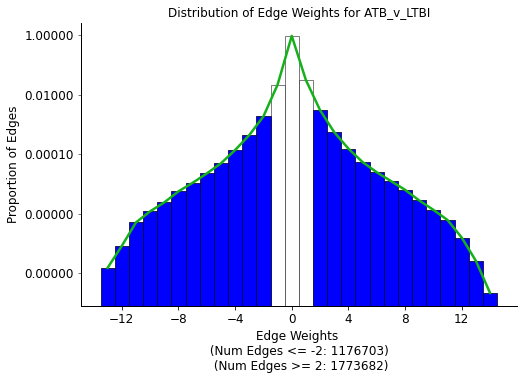

In [13]:
fig , ax = plt.subplots()

plot_distribution_of_edge_weights(ax, edge_weight_distr_counter_dict, f'Distribution of Edge Weights for {comparison_X}', 'xkcd:green')

fig = plt.gcf()
fig.set_size_inches(7.5, 5.5)
fig.tight_layout()

#file_name = '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/Figures/lab_meeting_12_12_19/pairwise_SNP_distance/distribution_of_pairwise_SNP_distances.png'
#plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

### Normalize Edge Weights?

In [14]:
np.min(network_edge_weight_matrix)

-13

In [15]:
np.max(network_edge_weight_matrix)

14

### Construct NetworkX graph from edge weight matrix

#### Retrieve the indices for the upper-triangular part of the matrix

In [16]:
#Return the upper triangular part of the matrix with elements in lower part ZEROED out
upper_tri_network_edge_weight_matrix = np.triu(network_edge_weight_matrix, k = 0)

#Return a boolean for elements in the upper triangular part of the matrix for elments that are <= -2 OR >= 2
upper_tri_network_edge_weight_matrix_bool = abs(upper_tri_network_edge_weight_matrix) >= 2

#get the indices for the elements in the upper triangle where elements (edge weights) <= -2 OR >= 2
node_i_indices = upper_tri_network_edge_weight_matrix_bool.nonzero()[0]
node_j_indices = upper_tri_network_edge_weight_matrix_bool.nonzero()[1]

#Create list of edges for NetworkX graph by iterating through numpy (adjancency) matrix (with edge weights) + node labels (rows/columns of matrix) & storing edges with weights <= -2 OR >= 2
G_edge_list = [ (network_edge_weight_matrix_labels[node_i], network_edge_weight_matrix_labels[node_j], network_edge_weight_matrix[node_i, node_j]) for node_i, node_j in zip(node_i_indices, node_j_indices)]

In [17]:
G_edge_list[0:20]

[('FANCD2', 'FANCD2', 3),
 ('FANCD2', 'TGFBR3', 3),
 ('FANCD2', 'EPHB6', 2),
 ('FANCD2', 'TMEM243', 2),
 ('FANCD2', 'TRIM68', 2),
 ('FANCD2', 'TIMM22', 2),
 ('FANCD2', 'C12orf57', 2),
 ('FANCD2', 'WRN', 2),
 ('FANCD2', 'CLEC2B', -2),
 ('FANCD2', 'CCDC85C', 2),
 ('FANCD2', 'CD6', 3),
 ('FANCD2', 'ZNF329', 2),
 ('FANCD2', 'IRAK1BP1', 3),
 ('FANCD2', 'CHMP5', -2),
 ('FANCD2', 'P2RY10', 2),
 ('FANCD2', 'TRIM32', 3),
 ('FANCD2', 'TOX2', 2),
 ('FANCD2', 'MAN1C1', 3),
 ('FANCD2', 'ACAD11', 2),
 ('FANCD2', 'GYPE', -2)]

In [18]:
len(G_edge_list) #number of edges (gene-gene pairs with edge weights <= -2 OR >= 2)

2950385

#### Construct NetworkX graph from list of Edges

In [19]:
G = nx.Graph()
G.add_weighted_edges_from(G_edge_list)

In [20]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 5433
Number of edges: 2950385
Average degree: 1086.0979


#### Calculation Degree Centrality from NetworkX graph (doesn't take edge weights into account)

In [28]:
centrality = nx.degree_centrality(G)
centrality = pd.Series(centrality) #convert to series

In [29]:
centrality.sort_values(ascending = False).head(n = 50)

FCGR1B      0.808358
CCR7        0.806701
FBXO6       0.806701
IL7R        0.806701
IFITM3      0.806701
SLC38A1     0.798601
SMARCD3     0.798601
SCO2        0.798049
VAMP5       0.798049
ABLIM1      0.796760
SERPING1    0.780560
C1QB        0.772459
BATF2       0.770619
S1PR1       0.765648
FLVCR2      0.764175
LAX1        0.756075
SYTL2       0.756075
ADM         0.748343
SKAP1       0.739507
TNFAIP6     0.739507
GK          0.739507
CAMP        0.737297
LY96        0.726436
GPR183      0.722754
TCN1        0.719993
IL1B        0.717968
ASGR2       0.714654
MMP9        0.713549
CD27        0.713549
CEACAM1     0.712997
GBP5        0.712997
SLC26A8     0.712997
AIM2        0.712997
FCGR1A      0.711708
MSRB2       0.711340
LILRA5      0.710972
LHFPL2      0.710788
LAP3        0.710604
BCL11B      0.710604
CD6         0.710604
DUSP3       0.710604
SPOCK2      0.710052
CLEC4D      0.710052
ETS1        0.704345
CD96        0.704345
ITK         0.704345
IFIT3       0.704345
CD247       0

Can convert edge weight matrix into a dataframe with gene labels

In [55]:
#Convert edge weight numpy array to DataFrame
network_edge_weight_df = pd.DataFrame(network_edge_weight_matrix , index = network_edge_weight_matrix_labels , columns = network_edge_weight_matrix_labels)

In [56]:
network_edge_weight_df.head()

,KRT36,KIFC3,REG4,FADS2,FANCD2,MIR181C,LOC645769,PEG13,CCDC130,FLJ11235,...,KIAA1826,STX11,LOC101928524,SYDE1,IL16,OSGEPL1,TAGAP,TCL1B,POM121L2,FUS
KRT36,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
KIFC3,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
REG4,0,0,1,0,0,0,0,0,-1,0,...,0,1,0,0,0,0,0,-1,0,0
FADS2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FANCD2,0,0,0,0,3,0,0,0,0,0,...,0,-2,0,0,0,1,0,0,0,1
